In [35]:
!pip install -U scikit-learn
!pip install autograd

# 1st Assignment: NN's from Scratch

The objective is to build from scratch a neural network to perform  classification. Let's firt consider the follwing 2-class dataset:

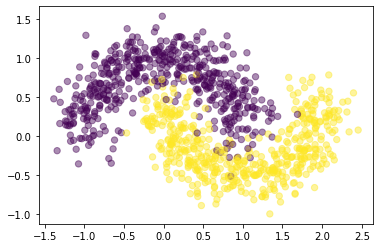

In [36]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a training dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45);

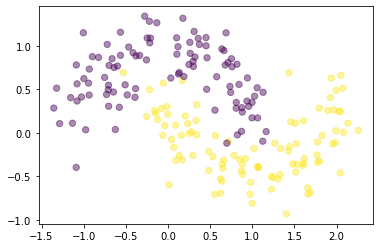

In [37]:
# Generate a testing dataset and plot it
np.random.seed(0)
Xt, yt = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(Xt[:,0], Xt[:,1], s=40, c=yt, alpha=0.45);

In [38]:
X[1], X.shape

(array([1.80460944, 0.00695963]), (1000, 2))

In [39]:
y[1], y.shape

(1, (1000,))

## Classification

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer. 

+ The number of nodes in the input layer will be determined by the dimensionality of our data (2). 
+ Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2). 

Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function $\sigma$. 


If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ \hat{y} = \mbox{softmax}({z_2})$$

where $\hat{y}$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network. 

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. 

## Softmax

The last layer is a `softmax` function. The softmax function is a generalization of the logistic function to multiple dimensions. It is used to normalize the output of a network to a probability distribution over predicted output classes.

The softmax function takes as input a vector $C$ of real numbers, and normalizes it into a probability distribution consisting of $C$ probabilities proportional to the exponentials of the input numbers:

$$softmax(z_i) = \frac{exp(z_i)}{\sum_{j=1}^{C}exp(z_j))}$$

## Cross-entropy loss

A common choice with the softmax output is the **cross-entropy loss**. 

If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [40]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function # (hidden layer, since output's is softmax)

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent

In [41]:
# loss function for a 3-layer MLP
def loss(model: dict) -> float:
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

# forward propagation
def predict(model: dict, x: np.ndarray) -> np.ndarray:
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [42]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

Loss after iteration 0: 0.578993
Loss after iteration 1000: 0.318070
Loss after iteration 2000: 0.297688
Loss after iteration 3000: 0.292829
Loss after iteration 4000: 0.289559
Loss after iteration 5000: 0.286088
Loss after iteration 6000: 0.281947
Loss after iteration 7000: 0.276860
Loss after iteration 8000: 0.270635
Loss after iteration 9000: 0.263206
Loss after iteration 10000: 0.254674
Loss after iteration 11000: 0.245306
Loss after iteration 12000: 0.235476
Loss after iteration 13000: 0.225571
Loss after iteration 14000: 0.215925
Loss after iteration 15000: 0.206780
Loss after iteration 16000: 0.198287
Loss after iteration 17000: 0.190518
Loss after iteration 18000: 0.183483
Loss after iteration 19000: 0.177156
Loss after iteration 20000: 0.171486
Loss after iteration 21000: 0.166413
Loss after iteration 22000: 0.161872
Loss after iteration 23000: 0.157801
Loss after iteration 24000: 0.154141
Loss after iteration 25000: 0.150836
Loss after iteration 26000: 0.147835
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

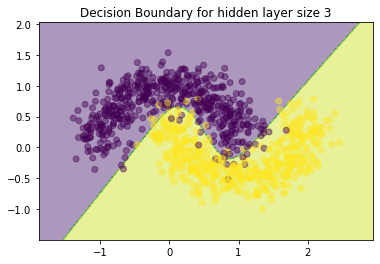

In [43]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

    
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 1

+ Report the classification accuracy using the testing dataset.

In [44]:
from sklearn.metrics import accuracy_score

def exercise1() -> None:
    y_hat = predict(model, Xt)
    print("\n The accuracy in the test set is: ", accuracy_score(yt, y_hat), 
          '\n', flush=True)
    
exercise1()


 The accuracy in the test set is:  0.955 



# Exercise 2

+ Add an additional layer to your neural network model. 
+ Change the activation function and use a ReLU. 


#### Below my solution for the 2nd exercise can be found. 

##### Naturally, since the complexity of network increased but the same training passes were kept (50000), the accuracy achieved on the test set was lower.

Loss after iteration 0: 0.608797
Loss after iteration 1000: 0.311775
Loss after iteration 2000: 0.298420
Loss after iteration 3000: 0.288472
Loss after iteration 4000: 0.282411
Loss after iteration 5000: 0.278174
Loss after iteration 6000: 0.274442
Loss after iteration 7000: 0.271007
Loss after iteration 8000: 0.267987
Loss after iteration 9000: 0.265382
Loss after iteration 10000: 0.263243
Loss after iteration 11000: 0.261471
Loss after iteration 12000: 0.259814
Loss after iteration 13000: 0.258426
Loss after iteration 14000: 0.257259
Loss after iteration 15000: 0.256271
Loss after iteration 16000: 0.255432
Loss after iteration 17000: 0.254715
Loss after iteration 18000: 0.254071
Loss after iteration 19000: 0.253494
Loss after iteration 20000: 0.252974
Loss after iteration 21000: 0.252542
Loss after iteration 22000: 0.252180
Loss after iteration 23000: 0.251862
Loss after iteration 24000: 0.251596
Loss after iteration 25000: 0.251372
Loss after iteration 26000: 0.251171
Loss after ite

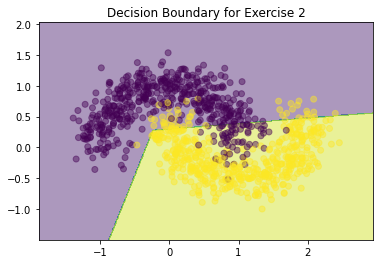

In [45]:
from autograd import grad
from autograd.misc import flatten
import sklearn.datasets
import sklearn.linear_model
from sklearn.metrics import accuracy_score
from typing import Any
import matplotlib
import autograd.numpy as np


# Display plots inline and change default figure size
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# # Generate a training dataset and plot it
# np.random.seed(0)
# X, y = sklearn.datasets.make_moons(1000, noise=0.20)

# # Generate a testing dataset and plot it
# np.random.seed(0)
# Xt, yt = sklearn.datasets.make_moons(200, noise=0.20)

# Set some parameters
nn_input_dim = 2  # input layer dimensionality
nn_output_dim = 2  # output layer dimensionality

# Gradient descent parameters
epsilon = 0.01  # learning rate for gradient descent


def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(0., x)


def forward_propagation(inputs: np.ndarray, model: Any) -> np.ndarray:
    w1, b1 = model['W1'], model['b1']
    w2, b2 = model['W2'], model['b2']
    w3, b3 = model['W3'], model['b3']
    z1 = np.dot(inputs, w1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, w2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, w3) + b3
    return z3


def compute_class_probabilities(inputs: np.ndarray, model: dict) -> np.ndarray:
    z3 = forward_propagation(inputs, model)
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probs


# loss function for a 3-layer MLP
def loss(model: dict, x: np.ndarray, y_: np.ndarray) -> float:
    num_examples = len(x)
    probs = compute_class_probabilities(x, model)

    # Calculating the loss
    correct_logprobs = -np.log(probs[range(num_examples), y_.astype(int)])
    data_loss = np.sum(correct_logprobs)

    return 1. / num_examples * data_loss


# forward propagation
def predict(model: dict, x: np.ndarray) -> np.ndarray:
    # Forward propagation to calculate our predictions
    return np.argmax(compute_class_probabilities(x, model), axis=1)


def build_model_and_train(x_: np.ndarray, y_: np.ndarray) -> dict:

    # Initialize the parameters to random values.
    np.random.seed(0)

    neurons1: int = 3
    w1 = np.random.randn(nn_input_dim, neurons1) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, neurons1))

    neurons2: int = 3
    w2 = np.random.randn(neurons1, neurons2) / np.sqrt(neurons1)
    b2 = np.zeros((1, neurons2))

    w3 = np.random.randn(neurons2, nn_output_dim) / np.sqrt(neurons2)
    b3 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {'W1': w1, 'b1': b1, 'W2': w2, 'b2': b2, 'W3': w3, 'b3': b3}

    # Gradient descent. For each batch...
    return gradient_descent(model, x_, y_)


def gradient_descent(model: dict, x_: np.ndarray, y_: np.ndarray,
                     epochs: int = 50000, print_loss: bool = True) -> dict:
    for i in range(0, epochs):

        # Forward propagation
        predict(model, x_)

        # computing the derivative by AD
        gradient_loss = grad(lambda _m: loss(_m, x_, y_))

        # flattening nested containers containing np arrays
        # Returns 1D np array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))

        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset,
        # so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" % (
                i, loss(model, x_, y_)))

    return model


def exercise2():
    # Build a model with a 3-dimensional hidden layer
    model = build_model_and_train(X, y)

    # Use the model for inference
    y_hat = predict(model, Xt)
    print("\n The accuracy in the test set is: ", accuracy_score(yt, y_hat))
    
    plot_decision_boundary(lambda x: predict(model, x))
    plt.title("Decision Boundary for Exercise 2")


if __name__ == '__main__':
    exercise2()

# Exercise 3

+ Design your own model (layers, activation function, number of units per layer, etc.) and train it to classify the following dataset. 
+ Train the model and report the classification accuracy using the testing dataset.


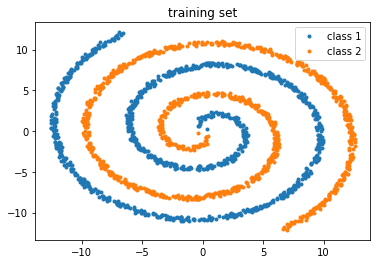

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def __two_spirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X_spir, y_spir = __two_spirals(1000)

plt.title('training set')
plt.plot(X_spir[y_spir==0,0], X_spir[y_spir==0,1], '.', label='class 1')
plt.plot(X_spir[y_spir==1,0], X_spir[y_spir==1,1], '.', label='class 2')
plt.legend()
plt.show()

# Generate a testing dataset and plot it
np.random.seed(0)
Xt_spir, yt_spir = __two_spirals(1000)

### The built classifier is based on the following arquitecture:
<ul>
    <li> 5 layers:
        <ul>
            <li> 4 ReLu layers with 6 neurons each </li> 
            <li> 1 output layers with 2 neurons (each of the categories) and no activation function</li>
        </ul>
    </li> 
    <li> The training was performed using 100000 passes (50 epochs) with a batch size of 50 and no regularization of any kind</li>
</ul>

Loss after iteration 0: 0.968218
Loss after iteration 10000: 0.656276
Loss after iteration 20000: 0.644516
Loss after iteration 30000: 0.631495
Loss after iteration 40000: 0.441485
Loss after iteration 50000: 0.331465
Loss after iteration 60000: 0.147642
Loss after iteration 70000: 0.006634
Loss after iteration 80000: 0.003224
Loss after iteration 90000: 0.002207

 The accuracy in the test set is:  0.999


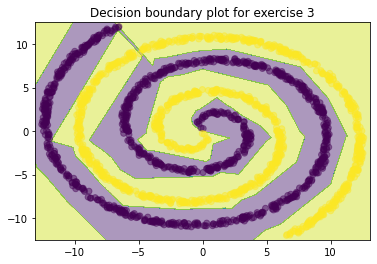

<Figure size 432x288 with 0 Axes>

In [51]:
from autograd import grad
from autograd.misc import flatten
from sklearn.metrics import accuracy_score
import matplotlib
import autograd.numpy as np
import matplotlib.pyplot as plt
from typing import Any

# Display plots inline and change default figure size
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Set some parameters
nn_input_dim = 2  # input layer dimensionality
nn_output_dim = 2  # output layer dimensionality

# Gradient descent parameters
epsilon = 0.01  # learning rate for gradient descent


def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(0., x)


def identity(x: np.ndarray) -> np.ndarray:
    return x


def forward_propagation(inputs: np.ndarray, model: Any) -> np.ndarray:
    w1, b1 = model['W1'], model['b1']
    w2, b2 = model['W2'], model['b2']
    w3, b3 = model['W3'], model['b3']
    w4, b4 = model['W4'], model['b4']
    w5, b5 = model['W5'], model['b5']
    z1 = np.dot(inputs, w1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, w2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, w3) + b3
    a3 = relu(z3)
    z4 = np.dot(a3, w4) + b4
    a4 = relu(z4)
    z5 = np.dot(a4, w5) + b5
    return z5


def compute_class_probabilities(inputs: np.ndarray, model: dict) -> np.ndarray:
    z3 = forward_propagation(inputs, model)
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probs


# loss function for a 3-layer MLP
def loss(model: dict, x: np.ndarray, y_: np.ndarray) -> float:
    num_examples = len(x)
    probs = compute_class_probabilities(x, model)

    # Calculating the loss
    correct_logprobs = -np.log(probs[range(num_examples), y_.astype(int)])
    data_loss = np.sum(correct_logprobs)

    return 1. / num_examples * data_loss


# forward propagation
def predict(model: dict, x: np.ndarray) -> np.ndarray:
    # Forward propagation to calculate our predictions
    return np.argmax(compute_class_probabilities(x, model), axis=1)


def build_model_and_train(x_: np.ndarray, y_: np.ndarray,
                          epochs: int = 1000) -> dict:

    # Initialize the parameters to random values.
    np.random.seed(0)

    neurons1: int = 6
    w1 = np.random.randn(nn_input_dim, neurons1) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, neurons1))

    neurons2: int = 6
    w2 = np.random.randn(neurons1, neurons2) / np.sqrt(neurons1)
    b2 = np.zeros((1, neurons2))

    neurons3: int = 6
    w3 = np.random.randn(neurons2, neurons3) / np.sqrt(neurons2)
    b3 = np.zeros((1, neurons3))

    neurons4: int = 6
    w4 = np.random.randn(neurons3, neurons4) / np.sqrt(neurons3)
    b4 = np.zeros((1, neurons4))

    # output layer
    w5 = np.random.randn(neurons4, nn_output_dim) / np.sqrt(neurons4)
    b5 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {'W1': w1, 'b1': b1, 'W2': w2, 'b2': b2, 'W3': w3, 'b3': b3,
             'W4': w4, 'b4': b4, 'W5': w5, 'b5': b5}

    # Gradient descent. For each batch...
    return gradient_descent(model, x_, y_, epochs=epochs)


def gradient_descent(model: dict, x_: np.ndarray, y_: np.ndarray,
                     epochs: int = 1000, print_loss: bool = True) -> dict:
    passes: int = x_.shape[0] * epochs
    for i in range(0, passes):

        # Forward propagation
        predict(model, x_)

        # computing the derivative by AD
        gradient_loss = grad(lambda _m: loss(_m, x_, y_))

        # flattening nested containers containing np arrays
        # Returns 1D np array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))

        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset,
        # so we don't want to do it too often.
        if print_loss and i % 10000 == 0:
            print("Loss after iteration %i: %f" % (
                i, loss(model, x_, y_)))

    return model


def plot_decision_boundary(x_: np.ndarray, y_: np.ndarray,
                           pred_func: callable,
                           plot_name: str = 'example') -> None:
    # Set min and max values and give it some padding
    x_min, x_max = x_[:, 0].min() - .5, x_[:, 0].max() + .5
    y_min, y_max = x_[:, 1].min() - .5, x_[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, z, alpha=0.45)
    plt.scatter(x_[:, 0], x_[:, 1], c=y_, alpha=0.45)
    plt.title("Decision boundary plot for exercise 3")
    plt.show();
    plt.savefig(f'output/{plot_name}.png')


def exercise3() -> None:
    """
    We are going to design a 5-layer classifier with ReLU
    as activation function and 6 neurons for each of them.
    """
    # Build a model with a 3-dimensional hidden layer
    model = build_model_and_train(X_spir, y_spir, epochs=50)

    # Use the model for inference
    y_hat = predict(model, Xt_spir)
    print("\n The accuracy in the test set is: ", accuracy_score(yt_spir, y_hat))

    plot_decision_boundary(Xt_spir, yt_spir, lambda x: predict(model, x),
                           plot_name='exercise3')


if __name__ == '__main__':
    exercise3()

# Bonus resolution

During the model design & building I was tired of changing between several hyperparameters settings and switching amongst different training procedures.

Thus, I thought about programming an API-like implementation of the model, based on a wrapper class called ``Model`` (very similar to Keras with respect to Kensorflow, specially with the idea of the ``add_layer`` method).

Below the implementation is presented and applied in order to solve the last exercise.

# Classifier model as a class: implementation

#### Auxiliary functions

In [2]:
from autograd import grad
from autograd.misc import flatten
from sklearn.metrics import accuracy_score
import matplotlib
import autograd.numpy as np
import matplotlib.pyplot as plt
from typing import Any

# Display plots inline and change default figure size
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Set some parameters
nn_input_dim = 2  # input layer dimensionality
nn_output_dim = 2  # output layer dimensionality

# Gradient descent parameters
epsilon = 0.01  # learning rate for gradient descent

############################################################################


def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(0., x)


def identity(x: np.ndarray) -> np.ndarray:
    return x


# NEEDED OUTSIDE TO BE DIFFERENTIATED by autograd

def forward_propagation(model: dict, activation_functions: list,
                        inputs: np.ndarray, n_layers: int) -> np.ndarray:
    assert n_layers, "The model needs at least 1 layer!"
    a_prev: np.ndarray = inputs
    a_curr: np.ndarray = None
    for n_ in range(1, n_layers + 1):
        w_curr = model[f'W{n_}']
        b_curr = model[f'b{n_}']
        z_curr = np.dot(a_prev, w_curr) + b_curr
        a_curr = activation_functions[n_ - 1](z_curr)

        a_prev = a_curr
    return a_curr


def compute_class_probabilities(
        model: dict, activation_functions: list,
        inputs: np.ndarray, n_layers: int) -> np.ndarray:
    exp_scores = np.exp(forward_propagation(model, activation_functions,
                                            inputs, n_layers))
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probs


def loss(model: dict, activation_functions: list,
         x_: np.ndarray, y_: np.ndarray, n_layers: int) -> float:
    num_examples: int = len(x_)
    probs = compute_class_probabilities(
        model, activation_functions, x_, n_layers)

    # Calculating the loss
    correct_logprobs = -np.log(probs[range(num_examples), y_.astype(int)])
    data_loss = np.sum(correct_logprobs)

    return 1. / num_examples * data_loss

# PLOTTING ##############################################################


def plot_decision_boundary(x_: np.ndarray, y_: np.ndarray,
                           pred_func: callable,
                           plot_name: str = 'exercise3') -> None:
    # Set min and max values and give it some padding
    x_min, x_max = x_[:, 0].min() - .5, x_[:, 0].max() + .5
    y_min, y_max = x_[:, 1].min() - .5, x_[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, z, alpha=0.45)
    plt.scatter(x_[:, 0], x_[:, 1], c=y_, alpha=0.45)
    plt.title("Decision boundary plot for exercise 3")
    plt.show();
    plt.savefig(f'output/{plot_name}.png')

# Class definition 

In [54]:
class Model:
    # Initialize the parameters to random values.
    np.random.seed(0)

    def __init__(self, input_dim: int) -> None:
        self._model: dict = {}
        self._activation_functions: list = []
        self._input_dim: int = input_dim
        self._n_layers: int = 0

    def add_layer(self, n_neurons: int, activation: callable) -> None:
        if self._n_layers == 0:
            neurons_prev = self._input_dim
        else:
            neurons_prev = self._model[f"b{self._n_layers}"].shape[1]

        _w = np.random.randn(neurons_prev, n_neurons) / np.sqrt(neurons_prev)
        _b = np.zeros((1, n_neurons))
        _func = activation

        self._n_layers += 1
        self._model[f"W{self._n_layers}"] = _w
        self._model[f"b{self._n_layers}"] = _b
        self._activation_functions.append(_func)

    def _compute_class_probabilities(self, inputs: np.ndarray) -> np.ndarray:
        return compute_class_probabilities(
            self._model, self._activation_functions, inputs, self._n_layers)

    # loss function for a 3-layer MLP
    def _loss(self, x_: np.ndarray, y_: np.ndarray) -> float:
        return loss(
            self._model, self._activation_functions, x_, y_, self._n_layers)

    # forward propagation
    def predict(self, x: np.ndarray) -> np.ndarray:
        # Forward propagation to calculate our predictions
        return np.argmax(self._compute_class_probabilities(x), axis=1)

    def train(self, x_: np.ndarray, y_: np.ndarray,
              epochs: int = 1000, print_loss: bool = True) -> None:
        assert self._n_layers > 0, \
            "You have to add at least 1 layer to be able to fit the classifier"
        passes: int = x_.shape[0] * epochs
        # Beginning of the gradient descent
        for i in range(0, passes):

            # computing the derivative by Automatic Differentiation
            gradient_loss = grad(lambda model_: loss(
                model_, self._activation_functions, x_, y_, self._n_layers))

            # flattening nested containers containing np arrays
            # Returns 1D np array and an unflatten function.
            model_flat, unflatten_m = flatten(self._model)
            grad_flat, unflatten_g = flatten(gradient_loss(self._model))

            # gradient descendW
            model_flat -= grad_flat * epsilon
            self._model = unflatten_m(model_flat)

            # TODO: implement early stopping
            # Optionally print the loss.
            # This is expensive because it uses the whole dataset,
            # so we don't want to do it too often.
            if print_loss and i % 10000 == 0:
                print("Loss after iteration %i: %f" % (i, self._loss(x_, y_)))

# Main/run function

As it can be seen, the accuracy achieved in the test set was perfect. The model was built with the best found arquitecture and enough passes among the samples to train it, that is:
<ul>
    <li> 6 layers:
        <ul>
            <li> 5 ReLu layers with 6 neurons each </li> 
            <li> 1 output layers with 2 neurons (each of the categories) and no activation function</li>
        </ul>
    </li> 
    <li> The training was performed using 100000 passes (50 epochs) with a batch size of 50 and no regularization of any kind</li>
</ul>

Loss after iteration 0: 0.711194
Loss after iteration 10000: 0.660067
Loss after iteration 20000: 0.604323
Loss after iteration 30000: 0.200718
Loss after iteration 40000: 0.165288
Loss after iteration 50000: 0.145151
Loss after iteration 60000: 0.050131
Loss after iteration 70000: 0.028826
Loss after iteration 80000: 0.000979
Loss after iteration 90000: 0.000433

 The accuracy in the test set is:  1.0


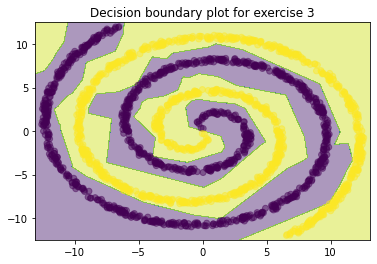

<Figure size 432x288 with 0 Axes>

In [55]:
def exercise3() -> None:
    """
    We are going to design a 6-layer classifier with ReLU
    as activation function and 6 neurons for each of them.
    """
    model = Model(nn_input_dim)
    model.add_layer(n_neurons=6, activation=relu)
    model.add_layer(n_neurons=6, activation=relu)
    model.add_layer(n_neurons=6, activation=relu)
    model.add_layer(n_neurons=6, activation=relu)
    model.add_layer(n_neurons=6, activation=relu)
    model.add_layer(n_neurons=nn_output_dim, activation=identity)  # output layer
    model.train(x_=X_spir, y_=y_spir, epochs=50)
    # Use the model for inference
    y_hat = model.predict(Xt_spir)
    print("\n The accuracy in the test set is: ", accuracy_score(yt_spir, y_hat))

    plot_decision_boundary(
        Xt_spir, yt_spir, model.predict, plot_name='exercise3_class')


if __name__ == '__main__':
    exercise3()